# Todo

* [MAYBE] add venn for ortholog only genes
* update all plots to latest versions
* make sure all points in text are covered here in the order presented.

**DONE**  
* plot control results - DONE
* test all for rerun_analysis = False - DONE
* test all for rerun_analysis = True - mostly tested, need to run the long ones - DONE

THIS NOTEBOOK SHOULD PRODUCE ALL PLOTS FOR FIGURE 2 + RELEVANT EXTENDED DATA FIGURES

# Introduction

This notebook loads

**Figures produced in this notebook:**
* Figure 2X. Venn diagram of overlap between input BMI gene sets
* Extended Data X. Distribution of mean $NPS_{hr}$ scores
* Figure 2X. Distribution of colocalized network sizes
* Figure 2X, Extended Data X. Scatter plots of $NPS_h$ vs $NPS_r$ defining the conserved BMI network
* Figure 2X. Venn diagram of overlap between rat and human input sets at the network level
* Extended Data X. Venn diagram of overlap between input height/body length gene sets
* Figure 2X. Bar plot of network colocalizations for control traits


**Note on rerunning the analysis:**
- If `rerun_analysis == False` (default) this notebook will load precomputed values for network propagation. The permutation analyses will still be rerun. Because the permutation analysis involves random shuffling of the data the results generated will differ slightly from those reported.
- If `rerun_analysis == True` this notebook will rerun all network propagation steps, including sampling analysis for human BMI and height. This requires significant memory (32GB+) and takes > 6 hours. Due to randomization in the sampling analysis the results generated will differ slightly from those reported. 


In [1]:
# set whether all analyses should be rerun (see note above)
rerun_analysis = True
if rerun_analysis:
    num_samples=100 # how many sampling runs should be performed (~2min per run)

# Set Up

In [2]:
# Import required libraries

import os
import sys
import ndex2
from getpass import getpass
import cdapsutil
import pandas as pd
import mygene
mg = mygene.MyGeneInfo()
from netcoloc import netprop_zscore, netprop

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2, venn3

DISCLAIMIER: cdapsutil is experimental and may contain errors and interfaces may change


In [3]:
# Set up directory paths. Defaults to the Data/ and Figures/ folders within the repository.
cwd = os.path.dirname(os.getcwd())
DATADIR = os.path.join(cwd, "Data/")
FIGDIR = os.path.join(cwd, "Figures/rerun_")

In [4]:
# Import functions specific to this study
sys.path.append(cwd)
from updated_netcoloc_functions import *
from analysis_functions import *
from plotting_functions import *

# Load Input Data

In [5]:
# insert load from raw data

## Load human and rat BMI seed genes

In [6]:
## Load the seed genes
seed_bin_human_BMI = pd.read_csv(DATADIR+"inputs/human_BMI_all_seed_genes.txt", header=None)[0].tolist()
print("Number of human BMI seeds:", len(seed_bin_human_BMI))

seed_bin_rat_BMI=pd.read_csv(DATADIR+'inputs/ratBMI_seed_relaxed.txt',sep='\t')['0'].tolist()
print("Number of rat BMI seeds:", len(seed_bin_rat_BMI))

Number of human BMI seeds: 1958
Number of rat BMI seeds: 295


In [7]:
# Initialize dictionary for storing the seed genes
seed_dict = {'hBMI': seed_bin_human_BMI, 'rBMI': seed_bin_rat_BMI}

## Load molecular interaction network

In [8]:
pc_nodes, G_PC = load_pcnet()

number of nodes:
18820

number of edges:
2693109


# Gene level overlap

In [9]:
def direct_overlap(all_nodes, seeds1, seeds2, labels=["Human", "Rat"], trait=""):
    hyper = hypergeom(M=len(all_nodes), n=len(seeds1), N=len(seeds2))
    intersect = set(seeds1).intersection(set(seeds2))
    p_intersect = hyper.sf(len(intersect))
    venn2([len(seeds1)-len(intersect), len(seeds2)-len(intersect), len(intersect)], labels,
     set_colors=('skyblue', 'purple'), alpha=0.7)
    _ = plt.title("-".join(labels) + " " +trait +" seed gene overlap, p="+str(p_intersect))

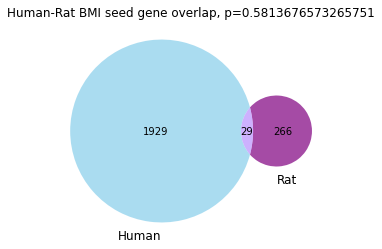

In [10]:
direct_overlap(pc_nodes, seed_bin_human_BMI, seed_bin_rat_BMI, trait="BMI")

# Perform BMI network colocalization

In [11]:
# set the number of repitions for determining the null distribution at each node
num_reps = 1000
# precalculate network propagation heats
if rerun_analysis:
    w_prime = netprop.get_normalized_adjacency_matrix(G_PC, conserve_heat=True, weighted=False)
    indiv_heats = netprop.get_individual_heats_matrix(w_prime, alpha=0.5)

## Calculate Z-scores

In [12]:
# Initialize dictionary for storing z-scores
z_dict = {}

### Human BMI

In [13]:
if rerun_analysis: # perform sampling analysis for network propagation
    BMI_pascal_results = pd.read_csv(DATADIR+"inputs/GIANT_BMI_pascal.sum.genescores.txt", sep="\t")
    BMI_samples = calculate_heat_zscores_with_sampling(BMI_pascal_results, pc_nodes, indiv_heats, G_PC, trait="BMI",
                                                            out_path=DATADIR+"outputs/rerun_", num_samples=num_samples)
    z_human_bin_BMI = get_consensus_z_scores(BMI_samples, 0.75)
else:  # use pre-calculated results
    z_human_bin_BMI = get_consensus_z_scores(DATADIR+'outputs/z_human_bin_BMI_SAMPLED_500_100_weighted.tsv')
z_dict['hBMI'] = z_human_bin_BMI

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

### Rat BMI

In [14]:
if rerun_analysis: # perform network propagation
    z_rat_BMI = netprop_zscore.calculate_heat_zscores(indiv_heats, list(G_PC.nodes),
                                                    dict(G_PC.degree), 
                                                    seed_bin_rat_BMI,
                                                    num_reps=num_reps, alpha=0.5,
                                                    minimum_bin_size=10,
                                                    random_seed=1)
    pd.DataFrame(z_rat_BMI[0], columns=["z"]).to_csv(DATADIR+"outputs/z_rat_BMI_rerun.tsv", sep="\t", index=True)
    z_dict['rBMI'] = pd.DataFrame(z_rat_BMI[0], columns=["z"])
else: # use precomputed values
    out_name = 'rat_BMI_relaxed'
    z_rat_BMI=pd.read_csv(DATADIR+'outputs/z_'+out_name+'_'+str(num_reps)+'_reps.tsv',sep='\t',
                          index_col='gene',names=['gene','z'], header=0)
    z_dict['rBMI'] = z_rat_BMI

  0%|          | 0/1000 [00:00<?, ?it/s]

## Permutation Analysis

In [15]:
# Generate a null distribution of mean NPS by shuffling the z_scores
observed_BMI, permuted_BMI = calculate_mean_z_score_distribution(z_dict['rBMI'], z_dict['hBMI'], num_reps=10000,
                                                       zero_double_negatives=False, overlap_control="bin",
                                                       seed1=seed_dict['rBMI'], seed2=seed_dict['hBMI'])

Overlap seed genes: 29


100%|██████████| 10000/10000 [01:01<00:00, 161.79it/s]


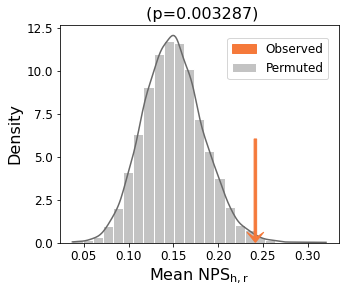

In [16]:
plot_permutation_histogram(permuted_BMI, observed_BMI,'', 'Mean $NPS_{h,r}$',color="dimgrey", arrow_color="#F5793A")
plt.savefig(FIGDIR + "ratBMI_humanBMI_mean_NPS_histogram_400dpi.png",dpi=400, bbox_inches="tight")

In [17]:
# Generate a null distribution of colocalized network size by shuffling the z_scores and applying the thresholds:
# NPS_r > 1, NPS_h > 1, NPS_hr > 3
observed_BMI_sz, permuted_BMI_sz = calculate_expected_overlap(z_dict['rBMI'], z_dict['hBMI'], 
                                                            z_score_threshold=3, z1_threshold=1.0,
                                                            z2_threshold=1.0, num_reps=10000, plot=False, 
                                                            overlap_control="bin",
                                                            seed1=seed_dict['rBMI'], seed2=seed_dict['hBMI'])

Overlap seed genes: 29


100%|██████████| 10000/10000 [02:14<00:00, 74.32it/s]


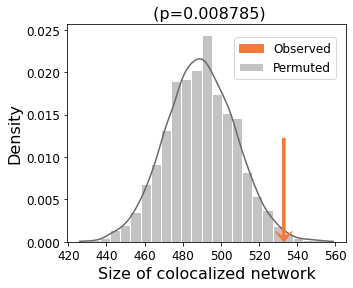

In [18]:
plot_permutation_histogram(permuted_BMI_sz, observed_BMI_sz,'', 'Size of colocalized network', color="dimgrey",
                          arrow_color="#F5793A")
plt.savefig(FIGDIR + "ratBMI_humanBMI_netcoloc_size_histogram_400dpi.png",dpi=400, bbox_inches="tight")

## Visualize results for BMI network colocalization

In [19]:
# compile z scores and seed gene status for each gene in the network
netcoloc_data = pd.DataFrame(z_dict['hBMI']).join(z_dict['rBMI'], lsuffix="_human", rsuffix="_rat")
netcoloc_data["human_seed"] = netcoloc_data.index.isin(seed_bin_human_BMI) * 1 
netcoloc_data["rat_seed"] = netcoloc_data.index.isin(seed_bin_rat_BMI) * 1 
netcoloc_data["hue"] = netcoloc_data.apply(lambda x: "#F5793A" if (x.z_human > 1) and (x.z_rat > 1) 
                                           and (x.z_human * x.z_rat > 3) else "grey", axis=1)
data_non_seed = netcoloc_data.loc[((netcoloc_data.rat_seed ==0) & (netcoloc_data.human_seed==0))]

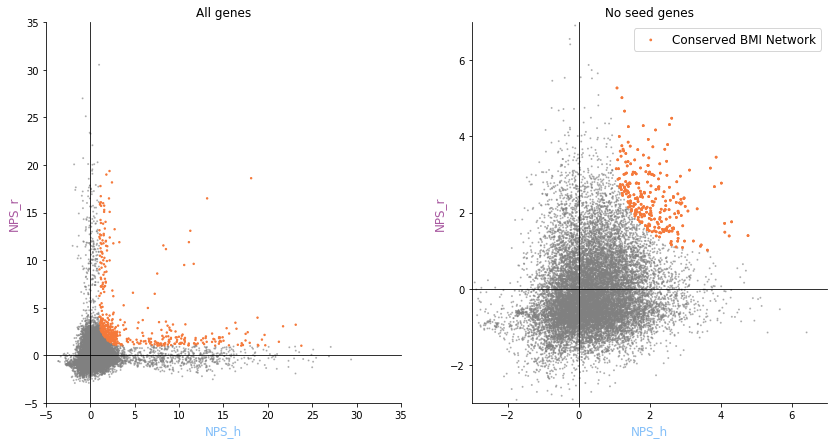

In [20]:
## scatter plot of species NPS scores 
fig, [ax1, ax2] = plt.subplots(1,2,figsize=(14,7))
ax1.scatter(data=netcoloc_data, x="z_human", y="z_rat", color="hue", 
                s=[1 if netcoloc_data.hue[i]=="grey" else 2 for i in range(len(netcoloc_data))], 
                alpha=[0.5 if netcoloc_data.hue[i]=="grey" else 1 for i in range(len(netcoloc_data))], 
                zorder=0, label=None)
ax1.spines['left'].set(position=('data', -5), zorder=2)
ax1.spines['bottom'].set(position=('data', -5), zorder=2)
ax1.set_xlabel("NPS_h", zorder=4, fontsize=12, color="#85c0F9")
ax1.set_ylabel("NPS_r", fontsize=12, color="#A95AA1")
ax1.spines['top'].set_position(('data', 0.0))
ax1.spines['right'].set_position(('data', 0.0))
ax1.set_xlim((-5, 35))
ax1.set_ylim((-5, 35))
_ =ax1.set_title("All genes")

ax2.scatter(data=data_non_seed, x="z_human", y="z_rat", color="hue", 
                s=[1 if data_non_seed.hue[i]=="grey" else 3 for i in range(len(data_non_seed))], 
                alpha=[0.5 if data_non_seed.hue[i]=="grey" else 1 for i in range(len(data_non_seed))], 
                zorder=0, label=None)
ax2.scatter(data = data_non_seed[data_non_seed.hue != "grey"], x="z_human", y="z_rat", color="hue", s=3, alpha=1, 
                zorder=1, label= "Conserved BMI Network" )
ax2.set_ylabel("NPS_r", fontsize=12, color="#A95AA1")
ax2.set_xlim((-3, 7))
ax2.set_ylim((-3, 7))
ax2.spines['left'].set(position=('data', -3), zorder=2)
ax2.spines['bottom'].set(position=('data', -3), zorder=2)
ax2.set_xlabel("NPS_h", zorder=4, fontsize=12, color="#85c0F9")
ax2.spines['top'].set_position(('data', 0.0))
ax2.spines['right'].set_position(('data', 0.0))
_ =ax2.set_title("No seed genes")
plt.legend(fontsize=12)

plt.savefig(FIGDIR + "BMI_NPS_scatter_plots_conserved_network.png", bbox_inches="tight", dpi=400)

In [21]:
## Get gene sets meeting each of the thresholds
h_set = set(netcoloc_data[netcoloc_data.z_human > 1].index)
r_set = set(netcoloc_data[netcoloc_data.z_rat > 1].index)
b_set = set(netcoloc_data[netcoloc_data.hue != "grey"].index)

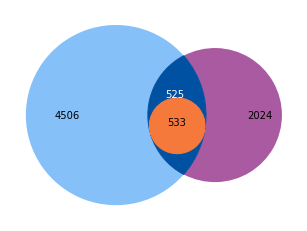

In [22]:
# create new venn diagram
c = venn3([h_set, r_set, b_set.intersection(h_set).intersection(r_set)], 
          set_colors = ["#85c0f9", "#a95aa1", "#f5793a"], alpha=1, set_labels=["", "", ""])
c.get_patch_by_id('111').set_color('#f5793a')
c.get_patch_by_id('110').set_color('#0051a2')
c.get_label_by_id('110').set_color('white')
plt.savefig("/cellar/users/snwright/Data/Transfer/rat/UpdatedFigures/PostColoc_venn3_v2.png", dpi=400, bbox_inches="tight")

# Control analysis

## Load control trait seed genes

### Positive Control Height/BL

In [23]:
seed_bin_human_height = load_human_seed_genes(DATADIR+'inputs/GIANT_standing_height_pascal.sum.genescores.txt', 
                                              pc_nodes, 'height')
seed_bin_rat_BL=pd.read_csv(DATADIR+'inputs/ratBL_seed_relaxed.txt',sep='\t')['0'].tolist()
print("Number of rat BL seeds:", len(seed_bin_rat_BL))

Number of height seeds: 6140
Number of rat BL seeds: 337


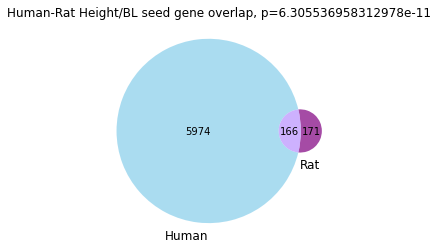

In [24]:
direct_overlap(pc_nodes, seed_bin_human_height, seed_bin_rat_BL, trait="Height/BL")

### Negative Controls

In [25]:
# Human control trait seed genes
seed_bin_human_AR = pd.read_csv(DATADIR+'inputs/humanAR_seed_PASCAL'+'_bonf.txt',
                               sep="\t")['0'].tolist() # Allergic Rhinitis
seed_bin_human_BP1 = pd.read_csv(DATADIR+'inputs/humanBP1_seed_PASCAL'+'_bonf.txt',
                               sep="\t")['0'].tolist() # Balding pattern 1
seed_bin_human_BP4 = pd.read_csv(DATADIR+'inputs/humanBP4_seed_PASCAL'+'_bonf.txt',
                               sep="\t")['0'].tolist() # Balding pattern 4
print("Number of AR seeds:", len(seed_bin_human_AR))
print("Number of BP1 seeds:", len(seed_bin_human_BP1))
print("Number of BP4 seeds:", len(seed_bin_human_BP4))

Number of AR seeds: 34
Number of BP1 seeds: 316
Number of BP4 seeds: 239


## Perform network colocalization of controls

### Z-scores

In [26]:
# positive control
if rerun_analysis:
    # human sampling analysis for network propagation
    height_pascal_results = pd.read_csv(DATADIR+"inputs/GIANT_standing_height_pascal.sum.genescores.txt", sep="\t")
    height_samples = calculate_heat_zscores_with_sampling(height_pascal_results, pc_nodes, indiv_heats, G_PC, trait="height",
                                                            out_path=DATADIR+"outputs/rerun_", num_samples=num_samples)
    z_human_bin_height = get_consensus_z_scores(height_samples, 0.75)
    z_dict['hHeight'] = z_human_bin_height
    # rat network propagation
    z_rat_BL = netprop_zscore.calculate_heat_zscores(indiv_heats, list(G_PC.nodes),
                                                    dict(G_PC.degree), 
                                                    seed_bin_rat_BL,
                                                    num_reps=num_reps, alpha=0.5,
                                                    minimum_bin_size=10,
                                                    random_seed=1)
    pd.DataFrame(z_rat_BL[0], columns=["z"]).to_csv(DATADIR+"outputs/z_rat_BL_rerun.tsv", sep="\t", index=True)
    z_dict['rBL'] = pd.DataFrame(z_rat_BL[0], columns=["z"])
else:
    # human precomputed scores
    z_human_bin_height = get_consensus_z_scores(DATADIR+'outputs/z_human_bin_Height_SAMPLED_500_100_weighted.tsv')
    z_dict['hHeight'] = z_human_bin_height
    # rat precomputed scores
    out_name = 'rat_BL_relaxed'
    z_rat_BL=pd.read_csv(DATADIR + 'outputs/z_'+out_name+'_'+str(num_reps)+'_reps.tsv',sep='\t',
                         index_col='gene', names=['gene', 'z'], header=0)
    z_dict['rBL'] = z_rat_BL

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [27]:
# negative controls
if rerun_analysis:
    # Allergic Rhinitis (AR)
    z_human_bin_AR = netprop_zscore.calculate_heat_zscores(indiv_heats, list(G_PC.nodes),
                                                    dict(G_PC.degree), 
                                                    seed_bin_human_AR,
                                                    num_reps=num_reps, alpha=0.5,
                                                    minimum_bin_size=10,
                                                    random_seed=1)
    pd.DataFrame(z_human_bin_AR[0], columns=["z"]).to_csv(DATADIR+"outputs/z_human_AR_rerun.tsv", sep="\t", index=True)
    z_dict['hAR'] = pd.DataFrame(z_human_bin_AR[0], columns=["z"])
    # Balding pattern 1 (BP1)
    z_human_bin_BP1 = netprop_zscore.calculate_heat_zscores(indiv_heats, list(G_PC.nodes),
                                                    dict(G_PC.degree), 
                                                    seed_bin_human_BP1,
                                                    num_reps=num_reps, alpha=0.5,
                                                    minimum_bin_size=10,
                                                    random_seed=1)
    pd.DataFrame(z_human_bin_BP1[0], columns=["z"]).to_csv(DATADIR+"outputs/z_human_BP1_rerun.tsv", sep="\t", index=True)
    z_dict['hBP1'] = pd.DataFrame(z_human_bin_BP1[0], columns=["z"])
    # Balding pattern 4 (BP4)
    z_human_bin_BP4 = netprop_zscore.calculate_heat_zscores(indiv_heats, list(G_PC.nodes),
                                                    dict(G_PC.degree), 
                                                    seed_bin_human_BP4,
                                                    num_reps=num_reps, alpha=0.5,
                                                    minimum_bin_size=10,
                                                    random_seed=1)
    pd.DataFrame(z_human_bin_BP4[0], columns=["z"]).to_csv(DATADIR+"outputs/z_human_BP4_rerun.tsv", sep="\t", index=True)
    z_dict['hBP4'] = pd.DataFrame(z_human_bin_BP4[0], columns=["z"])
else: # use precomputed scores
    out_name = 'human_AR_PASCAL'+'_bonf'
    z_human_bin_AR=pd.read_csv(DATADIR+'outputs/z_'+out_name+'_'+str(num_reps)+'_reps.tsv',sep='\t',
                            index_col='gene',names=['gene','z'], header=0)
    z_dict['hAR'] = z_human_bin_AR
    out_name = 'human_BP1_PASCAL'+'_bonf'
    z_human_bin_BP1=pd.read_csv(DATADIR+'outputs/z_'+out_name+'_'+str(num_reps)+'_reps.tsv',sep='\t',
                            index_col='gene',names=['gene','z'], header=0)
    z_dict['hBP1'] = z_human_bin_AR
    out_name = 'human_BP4_PASCAL'+'_bonf'
    z_human_bin_BP4=pd.read_csv(DATADIR+'outputs/z_'+out_name+'_'+str(num_reps)+'_reps.tsv',sep='\t',
                            index_col='gene',names=['gene','z'], header=0)
    z_dict['hBP4'] = z_human_bin_AR

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [28]:
# add control seed genes to the seed gene dictionary
seed_dict = {'hHeight': seed_bin_human_height,
    'rBMI':seed_bin_rat_BMI,'rBL':seed_bin_rat_BL,
             'hAR':seed_bin_human_AR,'hBP1':seed_bin_human_BP1,
             'hBP4':seed_bin_human_BP4, **seed_dict}

### Permutation analysis

In [29]:
# define the comparisons to be made
control_combinations = [('rBMI', 'hBMI'),('hHeight', 'rBL'), ('rBMI', 'rBL'), ('hBMI', 'hHeight'), ('rBMI', 'hAR'), ('rBMI', 'hBP1'),
                       ('rBMI', 'hBP4')]

In [30]:
control_results = []
for combo in control_combinations:
    observed, permuted = calculate_expected_overlap(z_dict[combo[0]], z_dict[combo[1]], 
                                                    z_score_threshold=3, z1_threshold=1.0,
                                                    z2_threshold=1.0, num_reps=1000, plot=False, 
                                                    overlap_control="bin",
                                                    seed1=seed_dict[combo[0]], seed2=seed_dict[combo[1]])
    control_results.append(get_permutation_stats(observed, permuted, "-".join(combo)))

Overlap seed genes: 29


100%|██████████| 1000/1000 [00:13<00:00, 74.58it/s]


Overlap seed genes: 166


100%|██████████| 1000/1000 [00:13<00:00, 74.25it/s]


Overlap seed genes: 25


100%|██████████| 1000/1000 [00:13<00:00, 74.69it/s]


Overlap seed genes: 1057


100%|██████████| 1000/1000 [00:13<00:00, 74.71it/s]


Overlap seed genes: 2


100%|██████████| 1000/1000 [00:13<00:00, 74.75it/s]


Overlap seed genes: 2


100%|██████████| 1000/1000 [00:13<00:00, 74.70it/s]


Overlap seed genes: 1


100%|██████████| 1000/1000 [00:13<00:00, 74.68it/s]


In [31]:
control_results = pd.concat(control_results)

## Load control network

To test whether the results are reproducible on a rat network we defined a high confidence rat network from STRING v11.5. From all links available for *R. norvegicus* we extracted all links with a score > 700 (equivalent to score > 0.7).

In [34]:
interactome_uuid='880c7d8c-f5ad-11ec-ac45-0ac135e8bacf' # for Rat String High Confidence
ndex_server='public.ndexbio.org'
ndex_user=None
ndex_password=None
G_rat_HC = ndex2.create_nice_cx_from_server(
            ndex_server, 
            username=ndex_user, 
            password=ndex_password, 
            uuid=interactome_uuid
        ).to_networkx()
nodes_rat_HC = list(G_rat_HC.nodes)

# remove any self edges
G_rat_HC.remove_edges_from(nx.selfloop_edges(G_rat_HC))

# remove unconnected nodes
remove_nodes = [n[0] for n in G_rat_HC.degree() if n[1]==0]
G_rat_HC.remove_nodes_from(remove_nodes)

# print out interactome num nodes and edges for diagnostic purposes
print('Number of nodes:')
print(len(G_rat_HC.nodes))
print('\nNumber of edges:')
print(len(G_rat_HC.edges))


Number of nodes:
16787

Number of edges:
277852


## Perform network colocalization of BMI on control network

In [35]:
# precalculate heats
if rerun_analysis:
    w_prime_rat_HC = netprop.get_normalized_adjacency_matrix(G_rat_HC, conserve_heat=True, weighted=False)
    indiv_heats_rat_HC = netprop.get_individual_heats_matrix(w_prime_rat_HC, alpha=0.5)

### Map seed genes to the rat network

In [36]:
# process ortholog mappings from HCOP
ortho_map = pd.read_csv(DATADIR + "Reference/human_rat_hcop_fifteen_column.txt.gz", sep="\t", index_col=None)
# restrict to entries with symbols for both species
ortho_map = ortho_map[(ortho_map["human_symbol"] != "-")]
ortho_map = ortho_map[(ortho_map["rat_symbol"] != "-")]
# restrict to entries with chromosome information
ortho_map = ortho_map[(ortho_map["human_chr"] != "-")]
ortho_map = ortho_map[(ortho_map["rat_chr"] != "-")]
# quantify number of supporting sources
ortho_map["N_sources"] = ortho_map.support.apply(lambda x: len(x.split(",")))
ortho_map = ortho_map.sort_values(by=["human_symbol", "N_sources"])

In [37]:
# map human BMI to rat
ortho_map_bmi = ortho_map[ortho_map.human_symbol.isin(seed_bin_human_BMI)]
# take ortholog supported by largest number of databases
seed_human_bmi_rat_orthos = ortho_map_bmi.drop_duplicates(subset="human_symbol", 
                                                          keep="last", ignore_index=True).loc[:, ("human_symbol", "rat_symbol")] 

In [38]:
# map rat BMI back to rat
ortho_map_bmi = ortho_map[ortho_map.human_symbol.isin(seed_bin_rat_BMI)]
# take ortholog supported by largest number of databases
seed_rat_bmi_rat_orthos = ortho_map_bmi.drop_duplicates(subset="human_symbol", 
                                                        keep="last", ignore_index=True).rat_symbol.unique() 

### Human Z-scores

In [39]:
if rerun_analysis:
    # map pascal results to rat genes
    BMI_pascal_results = pd.read_csv(DATADIR+"inputs/GIANT_BMI_pascal.sum.genescores.txt", sep="\t")
    mapped_pascal_results = BMI_pascal_results.merge(seed_human_bmi_rat_orthos, left_on="gene_symbol", right_on="human_symbol")
    mapped_pascal_results = mapped_pascal_results.drop(columns = "gene_symbol")
    mapped_pascal_results = mapped_pascal_results.rename(columns = {"rat_symbol":"gene_symbol"})
    # run the sampling network propagation
    BMI_samples_rat_HC = calculate_heat_zscores_with_sampling(mapped_pascal_results, nodes_rat_HC, 
                                                                      indiv_heats_rat_HC, G_rat_HC, trait="BMI",
                                                                        out_path=DATADIR+"outputs/rerun_rat_string_HC_",
                                                                            num_samples=num_samples)
    z_human_bin_BMI_rat_HC = get_consensus_z_scores(BMI_samples_rat_HC, 0.75)
else: # use precomputed results
    z_human_bin_BMI_rat_HC = get_consensus_z_scores(DATADIR+"outputs/rat_string_HC_BMIsampling_500_100.tsv", 
                                                                   0.75)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

### Rat Z-scores

In [40]:
if rerun_analysis: # perform network propagation
    z_rat_bmi_rat_net = netprop_zscore.calculate_heat_zscores(indiv_heats_rat_HC, list(G_rat_HC.nodes),
                                                    dict(G_rat_HC.degree), 
                                                    seed_rat_bmi_rat_orthos,
                                                    num_reps=num_reps,
                                                    minimum_bin_size=10,
                                                    random_seed=1)
    z_rat_bmi_rat_net = pd.DataFrame(z_rat_bmi_rat_net[0], columns=['z'])
else: # use precomputed results
    z_rat_bmi_rat_net = pd.read_csv(DATADIR + "outputs/rat_string_rat_zscores.tsv", header=None, sep="\t", index_col=0, names=["z"])
    z_rat_bmi_rat_net.index.name=None

  0%|          | 0/1000 [00:00<?, ?it/s]

### Permutation analysis

Overlap seed genes: 26


100%|██████████| 1000/1000 [00:12<00:00, 82.49it/s]


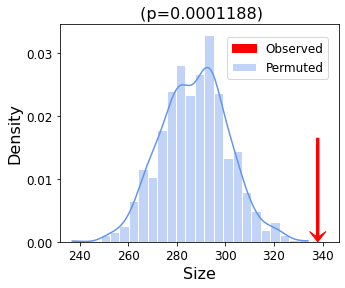

In [41]:
seeds_rat = [n for n in seed_rat_bmi_rat_orthos if n in nodes_rat_HC]
seeds_human = [n for n in seed_human_bmi_rat_orthos.rat_symbol.unique() if n in nodes_rat_HC]

# Generate a null distibution of conserved network sizes
observed_rat_HC, permuted_rat_HC = calculate_expected_overlap(z_rat_bmi_rat_net.fillna(0), 
                                                        z_human_bin_BMI_rat_HC.fillna(0), num_reps=1000,
                                                        overlap_control="bin",
                                                       seed1=seeds_rat, seed2=seeds_human)
plot_permutation_histogram(permuted_rat_HC, observed_rat_HC,'', 'Size')

In [42]:
# Add to the control results
control_results = pd.concat([control_results, get_permutation_stats(observed_rat_HC, permuted_rat_HC, "BMI_RatSTRING") ])

In [43]:
control_results

,Mean,Upper,Lower,p
rBMI-hBMI,1.091934,1.161220,1.028958,7.174000e-03
hHeight-rBL,1.116466,1.189944,1.044118,1.942000e-03
rBMI-rBL,1.242050,1.351351,1.149425,3.118000e-07
hBMI-hHeight,1.247097,1.311148,1.190332,8.770000e-18
rBMI-hAR,0.858914,0.948837,0.787645,9.949000e-01
rBMI-hBP1,0.990980,1.080000,0.911043,5.891000e-01
rBMI-hBP4,0.942645,1.027226,0.866450,8.807000e-01
BMI_RatSTRING,1.179305,1.275472,1.090323,1.188000e-04


## Plot results of control analysis

Orange: BMI/BMI
White: Positive Controls
Grey: Negative Controls


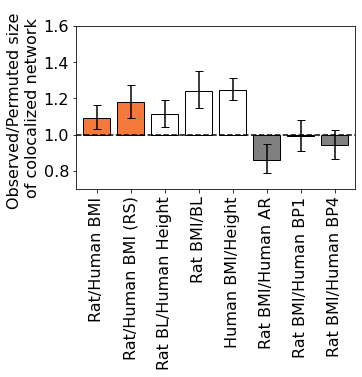

In [44]:
plt.figure(figsize=(5, 3))
plot_results = control_results.loc[["rBMI-hBMI",  "BMI_RatSTRING","hHeight-rBL", "rBMI-rBL", "hBMI-hHeight", "rBMI-hAR","rBMI-hBP1", "rBMI-hBP4"]]
plt.bar(x = ["rBMI-hBMI",  "BMI_RatSTRING","hHeight-rBL", "rBMI-rBL", "hBMI-hHeight", "rBMI-hAR","rBMI-hBP1", "rBMI-hBP4"],
       bottom= 1, height = plot_results.Mean - 1, capsize=4, edgecolor="black",
        yerr = [plot_results.Mean - plot_results.Lower, plot_results.Upper - plot_results.Mean],
       color = ["#f5793a"]*2 + ["white"]*3 + ["grey"]*3)

plt.xticks(fontsize=16, rotation=90, ticks=["rBMI-hBMI",  "BMI_RatSTRING","hHeight-rBL", "rBMI-rBL", "hBMI-hHeight", "rBMI-hAR","rBMI-hBP1", "rBMI-hBP4"], 
          labels = ["Rat/Human BMI", "Rat/Human BMI (RS)",  "Rat BL/Human Height","Rat BMI/BL","Human BMI/Height",
                   "Rat BMI/Human AR", "Rat BMI/Human BP1", "Rat BMI/Human BP4"])
plt.yticks(fontsize=16)
plt.hlines(y=1, xmin=-0.6, xmax=7.6, linestyle="dashed", color="black")
plt.ylabel("Observed/Permuted size \nof colocalized network", fontsize=16)
plt.xlim(-0.6, 7.6)
plt.ylim(0.7, 1.6)
plt.savefig("/cellar/users/snwright/Data/Transfer/rat/control_plot_July2.png", bbox_inches="tight", dpi=400)
print("Orange: BMI/BMI\nWhite: Positive Controls\nGrey: Negative Controls")